In [ ]:
import librosa
import noisereduce as nr
import numpy as np
import os
import soundfile as sf

# Constants
SAMPLE_RATE = 22050
STFT_WINDOW_LENGTH = 2048
HOP_LENGTH = 256

# Directories
# Replace these paths with the actual paths on your system
base_input_dir = r'/content/drive/MyDrive/animals'
base_output_dir = r'/content/drive/MyDrive/pres_new1'

categories = ['normal call', 'estrus call', 'food anticipating call', 'cough sound']

# Create the output directories if they don't exist
os.makedirs(base_output_dir, exist_ok=True)
for category in categories:
    os.makedirs(os.path.join(base_output_dir, category), exist_ok=True)

# Process each category
for category in categories:
    input_dir = os.path.join(base_input_dir, category)
    output_dir = os.path.join(base_output_dir, category)

    # Process each file in the category directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(input_dir, filename)
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Perform noise reduction
            clean_signal = nr.reduce_noise(y=y, sr=sr)

            # Save the preprocessed audio file
            output_file_path = os.path.join(output_dir, f'{os.path.splitext(filename)[0]}_clean.wav')
            sf.write(output_file_path, clean_signal, sr)
print("preprocessing complete")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


preprocessing complete


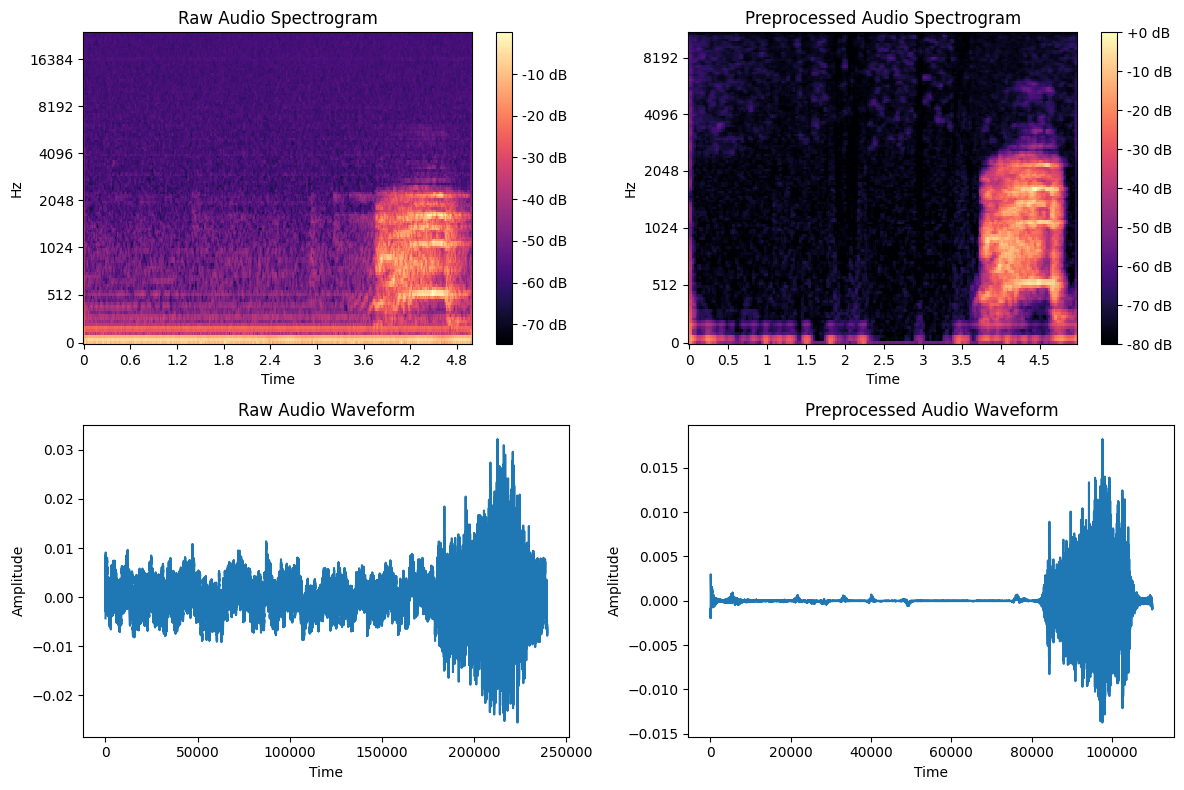

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Function to plot spectrograms and waveforms
def plot_spectrograms_and_waveforms(raw_audio_path, preprocessed_audio_path):
    # Load raw audio
    raw_audio, sr_raw = librosa.load(raw_audio_path, sr=None)
    # Load preprocessed audio
    preprocessed_audio, sr_preprocessed = librosa.load(preprocessed_audio_path, sr=None)

    # Compute spectrogram for raw audio
    raw_spec = librosa.feature.melspectrogram(y=raw_audio, sr=sr_raw)
    raw_spec_db = librosa.power_to_db(raw_spec, ref=np.max)
    # Compute spectrogram for preprocessed audio
    preprocessed_spec = librosa.feature.melspectrogram(y=preprocessed_audio, sr=sr_preprocessed)
    preprocessed_spec_db = librosa.power_to_db(preprocessed_spec, ref=np.max)

    # Plot spectrogram and waveform for raw audio
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    librosa.display.specshow(raw_spec_db, sr=sr_raw, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Raw Audio Spectrogram')

    plt.subplot(2, 2, 3)
    plt.plot(raw_audio)
    plt.title('Raw Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot spectrogram and waveform for preprocessed audio
    plt.subplot(2, 2, 2)
    librosa.display.specshow(preprocessed_spec_db, sr=sr_preprocessed, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Preprocessed Audio Spectrogram')

    plt.subplot(2, 2, 4)
    plt.plot(preprocessed_audio)
    plt.title('Preprocessed Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Specify paths to raw and preprocessed audio files
raw_audio_path = r'/content/drive/MyDrive/animals/normal call/S3$20191022-085243-c.wav'
preprocessed_audio_path = r'/content/drive/MyDrive/pres_new1/normal call/S3$20191022-085243-c_clean.wav'

# Plot spectrograms and waveforms
plot_spectrograms_and_waveforms(raw_audio_path, preprocessed_audio_path)

In [ ]:
import os

def count_files_in_folders(directory):
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        print(f"Number of files in '{folder}' folder: {len(files)}")

# Specify the directory you want to examine
directory_path = r'/content/drive/MyDrive/pres_new1'  # Change this to your directory path

count_files_in_folders(directory_path)


Number of files in 'normal call' folder: 42
Number of files in 'estrus call' folder: 117
Number of files in 'food anticipating call' folder: 100
Number of files in 'cough sound' folder: 11


In [ ]:
import os
from sklearn.model_selection import train_test_split

# Define the directory containing your dataset
dataset_directory = r'/content/drive/MyDrive/pres_new1'

# Gather file paths for each category
file_paths = []
labels = []

for category in os.listdir(dataset_directory):
    category_dir = os.path.join(dataset_directory, category)
    if os.path.isdir(category_dir):
        for file_name in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file_name)
            file_paths.append(file_path)
            labels.append(category)

# Split the data into training and test sets (80% train, 20% test)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Print the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of test files: {len(test_files)}")


Number of training files: 216
Number of test files: 54


# **VGG 16**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = (224, 224)  # Standard input size for VGG16
BATCH_SIZE = 32
EPOCHS = 250

# Paths
mfcc_images_dir = r'/content/drive/MyDrive/mfcc2'  # Path to MFCC images directory
weights_path = r'/content/drive/MyDrive/weight_file/vgg16_weights.h5'  # Path to save model weights
model_path = r'/content/drive/MyDrive/weight_file/vgg16_model.h5'  # Path to save entire model

# Number of unique classes
number_of_classes = 4

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load VGG16 model with pre-trained ImageNet weights, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add new classification layers on top
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(number_of_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = Falsex

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to see the total number of parameters
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model weights
model.save_weights(weights_path)

# Save the entire model
model.save(model_path)


Found 217 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


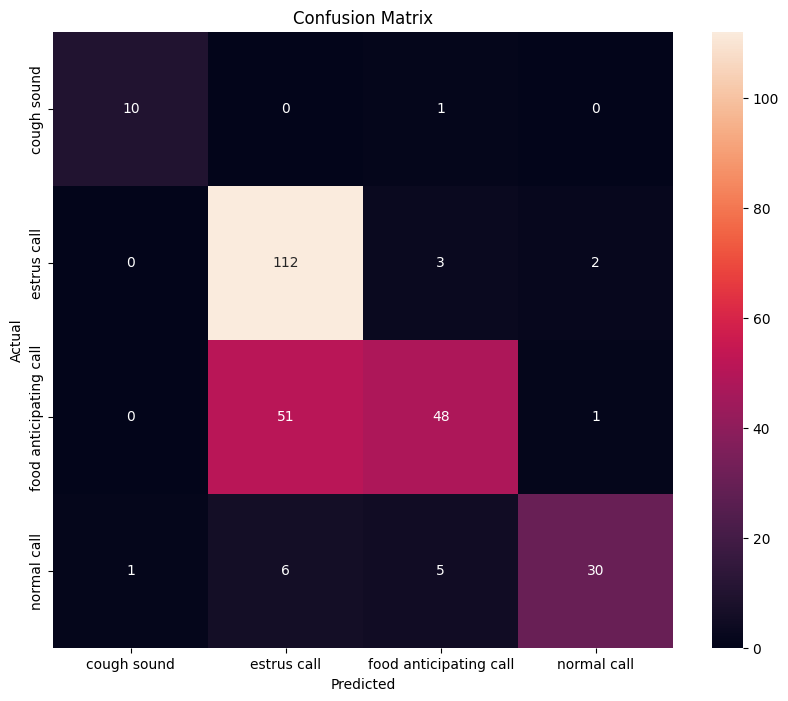

Accuracy: 74.07%
Precision: 83.08%
Recall: 76.52%
F1 Score: 77.59%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image

# Constants
SAMPLE_RATE = 22050
STFT_WINDOW_LENGTH = 2048
HOP_LENGTH = 256
N_MFCC = 13
N_FFT = 2048

# Define the base directory paths for preprocessed audio files
base_test_dir = r'/content/drive/MyDrive/pres_new1'

# Output directory for MFCC images
mfcc_output_dir = r'/content/drive/MyDrive/mfcc2_1_test'
os.makedirs(mfcc_output_dir, exist_ok=True)

# Load the trained model
model_path = r'/content/drive/MyDrive/weight_file/vgg16_model.h5'
model = load_model(model_path)

# Assuming class indices mapping
class_indices = {'cough sound': 0, 'estrus call': 1, 'food anticipating call': 2, 'normal call': 3}
index_to_class = {v: k for k, v in class_indices.items()}

predicted_labels = []
true_labels = []

def preprocess_audio(audio_input_path, preprocessed_output_path):
    y, sr = librosa.load(audio_input_path, sr=SAMPLE_RATE)
    clean_signal = nr.reduce_noise(y=y, sr=sr)
    sf.write(preprocessed_output_path, clean_signal, sr)

def generate_mfcc_image(preprocessed_audio_path, mfcc_image_output_path):
    y, sr = librosa.load(preprocessed_audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig('temp_mfcc.png')
    plt.close()

    # Open the saved image and resize it to (224, 224)
    image = Image.open('temp_mfcc.png')
    resized_image = image.resize((224, 224))
    resized_image.save(mfcc_image_output_path)

def predict_class(mfcc_image_path, model):
    img = load_img(mfcc_image_path, target_size=(224, 224), color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index

# Process each category
for category in class_indices:
    category_dir = os.path.join(base_test_dir, category)
    output_category_dir = os.path.join(mfcc_output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    # Process each audio file in the category directory
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            audio_input_path = os.path.join(category_dir, filename)
            preprocessed_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_preprocessed.wav")
            mfcc_image_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_mfcc.png")

            # Step 1: Preprocess the audio
            preprocess_audio(audio_input_path, preprocessed_output_path)

            # Step 2: Generate MFCC Image
            generate_mfcc_image(preprocessed_output_path, mfcc_image_output_path)

            # Step 3: Predict the class of the audio
            predicted_class_index = predict_class(mfcc_image_output_path, model)
            predicted_labels.append(predicted_class_index)
            true_labels.append(class_indices[category])

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


# **Resnet-50**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = (224, 224)  # Standard input size for ResNet50
BATCH_SIZE = 32
EPOCHS = 250

# Paths
mfcc_images_dir = r'/content/drive/MyDrive/mfcc2'  # Path to MFCC images directory
weights_path = r'/content/drive/MyDrive/weight_file/resnet50_weights.h5'  # Path to save model weights
model_path = r'/content/drive/MyDrive/weight_file/resnet50_model.h5'  # Path to save entire model

# Number of unique classes
number_of_classes = 4

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load ResNet50 model with pre-trained ImageNet weights, without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add new classification layers on top
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(number_of_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to see the total number of parameters
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model weights
model.save_weights(weights_path)

# Save the entire model
model.save(model_path)


Found 217 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
94765736/94765736 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


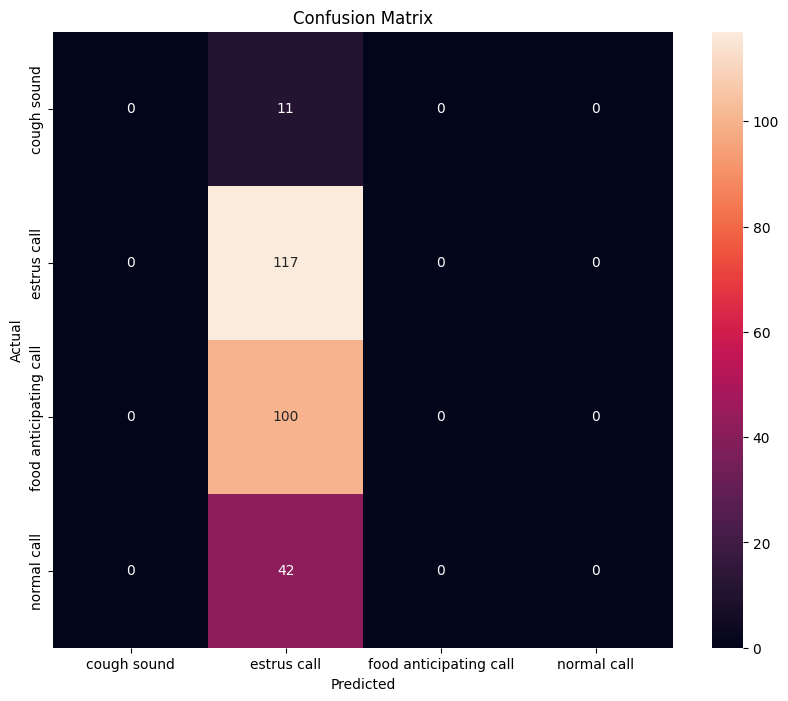

Accuracy: 43.33%
Precision: 10.83%
Recall: 25.00%
F1 Score: 15.12%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image

# Constants
SAMPLE_RATE = 22050
STFT_WINDOW_LENGTH = 2048
HOP_LENGTH = 256
N_MFCC = 13
N_FFT = 2048

# Define the base directory paths for preprocessed audio files
base_test_dir = r'/content/drive/MyDrive/pres_new1'

# Output directory for MFCC images
mfcc_output_dir = r'/content/drive/MyDrive/mfcc2_2_test'
os.makedirs(mfcc_output_dir, exist_ok=True)

# Load the trained model
model_path = r'/content/drive/MyDrive/weight_file/resnet50_model.h5'
model = load_model(model_path)

# Assuming class indices mapping
class_indices = {'cough sound': 0, 'estrus call': 1, 'food anticipating call': 2, 'normal call': 3}
index_to_class = {v: k for k, v in class_indices.items()}

predicted_labels = []
true_labels = []

def preprocess_audio(audio_input_path, preprocessed_output_path):
    y, sr = librosa.load(audio_input_path, sr=SAMPLE_RATE)
    clean_signal = nr.reduce_noise(y=y, sr=sr)
    sf.write(preprocessed_output_path, clean_signal, sr)

def generate_mfcc_image(preprocessed_audio_path, mfcc_image_output_path):
    y, sr = librosa.load(preprocessed_audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig('temp_mfcc.png')
    plt.close()

    # Open the saved image and resize it to (224, 224)
    image = Image.open('temp_mfcc.png')
    resized_image = image.resize((224, 224))
    resized_image.save(mfcc_image_output_path)

def predict_class(mfcc_image_path, model):
    img = load_img(mfcc_image_path, target_size=(224, 224), color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index

# Process each category
for category in class_indices:
    category_dir = os.path.join(base_test_dir, category)
    output_category_dir = os.path.join(mfcc_output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    # Process each audio file in the category directory
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            audio_input_path = os.path.join(category_dir, filename)
            preprocessed_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_preprocessed.wav")
            mfcc_image_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_mfcc.png")

            # Step 1: Preprocess the audio
            preprocess_audio(audio_input_path, preprocessed_output_path)

            # Step 2: Generate MFCC Image
            generate_mfcc_image(preprocessed_output_path, mfcc_image_output_path)

            # Step 3: Predict the class of the audio
            predicted_class_index = predict_class(mfcc_image_output_path, model)
            predicted_labels.append(predicted_class_index)
            true_labels.append(class_indices[category])

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


# **Inception v3**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = (299, 299)  # Standard input size for InceptionV3
BATCH_SIZE = 32
EPOCHS = 250

# Paths
mfcc_images_dir = r'/content/drive/MyDrive/mfcc2'  # Path to MFCC images directory
weights_path = r'/content/drive/MyDrive/weight_file/inceptionv3_weights.h5'  # Path to save model weights
model_path = r'/content/drive/MyDrive/weight_file/inceptionv3_model.h5'  # Path to save entire model

# Number of unique classes
number_of_classes = 4

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load InceptionV3 model with pre-trained ImageNet weights, without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

# Add new classification layers on top
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(number_of_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to see the total number of parameters
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model weights
model.save_weights(weights_path)

# Save the entire model
model.save(model_path)


Found 217 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
87910968/87910968 [==============================] - 3s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 306ms/step


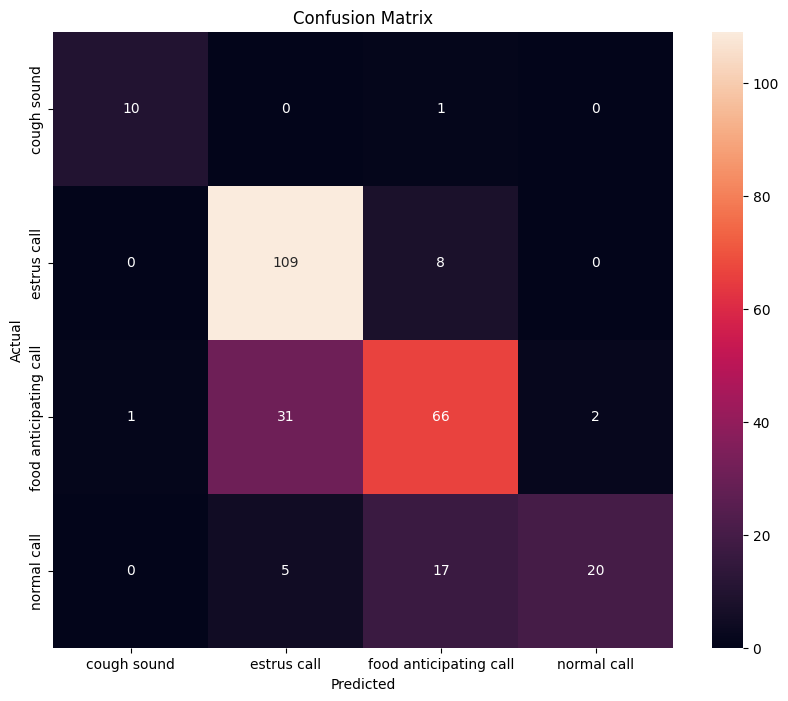

Accuracy: 75.93%
Precision: 82.18%
Recall: 74.42%
F1 Score: 76.34%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image
import noisereduce as nr  # Import the noisereduce library


# Constants
SAMPLE_RATE = 22050
STFT_WINDOW_LENGTH = 2048
HOP_LENGTH = 256
N_MFCC = 13
N_FFT = 2048
IMAGE_SIZE = (299, 299)  # Standard input size for InceptionV3

# Define the base directory paths for preprocessed audio files
base_test_dir = r'/content/drive/MyDrive/pres_new1'

# Output directory for MFCC images
mfcc_output_dir = r'/content/drive/MyDrive/mfcc2_3_test'
os.makedirs(mfcc_output_dir, exist_ok=True)

# Load the trained model
model_path = r'/content/drive/MyDrive/weight_file/inceptionv3_model.h5'
model = load_model(model_path)

# Assuming class indices mapping
class_indices = {'cough sound': 0, 'estrus call': 1, 'food anticipating call': 2, 'normal call': 3}
index_to_class = {v: k for k, v in class_indices.items()}

predicted_labels = []
true_labels = []

def preprocess_audio(audio_input_path, preprocessed_output_path):
    y, sr = librosa.load(audio_input_path, sr=SAMPLE_RATE)
    clean_signal = nr.reduce_noise(y=y, sr=sr)
    sf.write(preprocessed_output_path, clean_signal, sr)

def generate_mfcc_image(preprocessed_audio_path, mfcc_image_output_path):
    y, sr = librosa.load(preprocessed_audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig('temp_mfcc.png')
    plt.close()

    # Open the saved image and resize it to (299, 299)
    image = Image.open('temp_mfcc.png')
    resized_image = image.resize(IMAGE_SIZE)
    resized_image.save(mfcc_image_output_path)

def predict_class(mfcc_image_path, model):
    img = load_img(mfcc_image_path, target_size=IMAGE_SIZE, color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index

# Process each category
for category in class_indices:
    category_dir = os.path.join(base_test_dir, category)
    output_category_dir = os.path.join(mfcc_output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    # Process each audio file in the category directory
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            audio_input_path = os.path.join(category_dir, filename)
            preprocessed_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_preprocessed.wav")
            mfcc_image_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_mfcc.png")

            # Step 1: Preprocess the audio
            preprocess_audio(audio_input_path, preprocessed_output_path)

            # Step 2: Generate MFCC Image
            generate_mfcc_image(preprocessed_output_path, mfcc_image_output_path)

            # Step 3: Predict the class of the audio
            predicted_class_index = predict_class(mfcc_image_output_path, model)
            predicted_labels.append(predicted_class_index)
            true_labels.append(class_indices[category])

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


# **Efficient net**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Constants
IMAGE_SIZE = (224, 224)  # Standard input size for EfficientNetB0
BATCH_SIZE = 32
EPOCHS = 250

# Paths
mfcc_images_dir = r'/content/drive/MyDrive/mfcc2'  # Path to MFCC images directory
weights_path = r'/content/drive/MyDrive/weight_file/efficientnetb0_weights.h5'  # Path to save model weights
model_path = r'/content/drive/MyDrive/weight_file/efficientnetb0_model.h5'  # Path to save entire model

# Number of unique classes
number_of_classes = 4

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load EfficientNetB0 model with pre-trained ImageNet weights, without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add new classification layers on top
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(number_of_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to see the total number of parameters
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model weights
model.save_weights(weights_path)

# Save the entire model
model.save(model_path)


Found 217 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


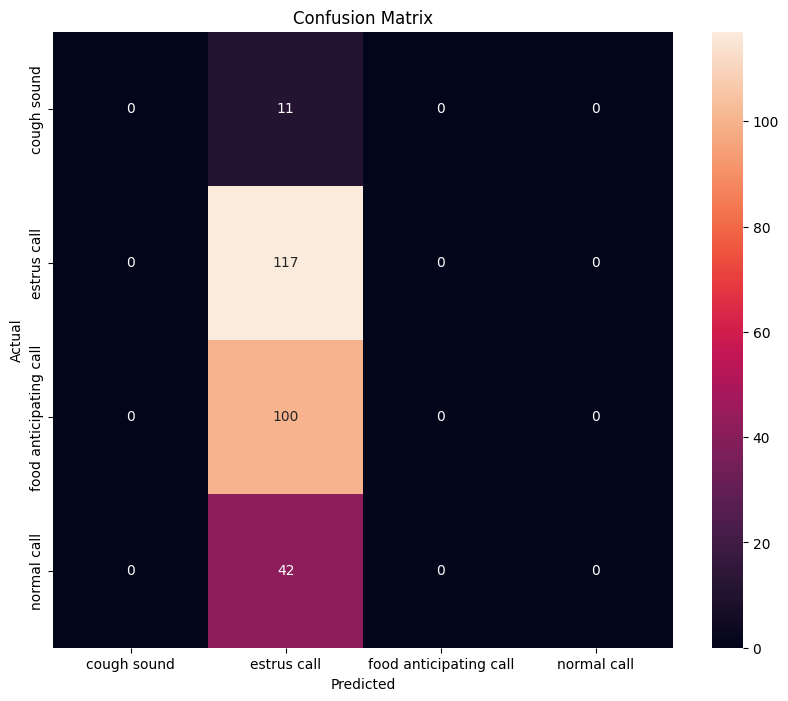

Accuracy: 43.33%
Precision: 10.83%
Recall: 25.00%
F1 Score: 15.12%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image
import noisereduce as nr

# Constants
SAMPLE_RATE = 22050
STFT_WINDOW_LENGTH = 2048
HOP_LENGTH = 256
N_MFCC = 13
N_FFT = 2048
IMAGE_SIZE = (224, 224)  # EfficientNet input size

# Define the base directory paths for preprocessed audio files
base_test_dir = r'/content/drive/MyDrive/pres_new1'

# Output directory for MFCC images
mfcc_output_dir = r'/content/drive/MyDrive/mfcc2_3_test'
os.makedirs(mfcc_output_dir, exist_ok=True)

# Load the trained model
model_path = r'/content/drive/MyDrive/weight_file/efficientnetb0_model.h5'  # Assuming you've saved EfficientNet as an h5 file
model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})

# Assuming class indices mapping
class_indices = {'cough sound': 0, 'estrus call': 1, 'food anticipating call': 2, 'normal call': 3}
index_to_class = {v: k for k, v in class_indices.items()}

predicted_labels = []
true_labels = []

def preprocess_audio(audio_input_path, preprocessed_output_path):
    y, sr = librosa.load(audio_input_path, sr=SAMPLE_RATE)
    clean_signal = nr.reduce_noise(y=y, sr=sr)
    sf.write(preprocessed_output_path, clean_signal, sr)

def generate_mfcc_image(preprocessed_audio_path, mfcc_image_output_path):
    y, sr = librosa.load(preprocessed_audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig('temp_mfcc.png')
    plt.close()

    # Open the saved image and resize it to (224, 224) for EfficientNet input
    image = Image.open('temp_mfcc.png')
    resized_image = image.resize(IMAGE_SIZE)
    resized_image.save(mfcc_image_output_path)

def predict_class(mfcc_image_path, model):
    img = load_img(mfcc_image_path, target_size=IMAGE_SIZE, color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index

# Process each category
for category in class_indices:
    category_dir = os.path.join(base_test_dir, category)
    output_category_dir = os.path.join(mfcc_output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    # Process each audio file in the category directory
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            audio_input_path = os.path.join(category_dir, filename)
            preprocessed_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_preprocessed.wav")
            mfcc_image_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_mfcc.png")

            # Step 1: Preprocess the audio
            preprocess_audio(audio_input_path, preprocessed_output_path)

            # Step 2: Generate MFCC Image
            generate_mfcc_image(preprocessed_output_path, mfcc_image_output_path)

            # Step 3: Predict the class of the audio
            predicted_class_index = predict_class(mfcc_image_output_path, model)
            predicted_labels.append(predicted_class_index)
            true_labels.append(class_indices[category])

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFViTModel, ViTFeatureExtractor
from tensorflow_addons.optimizers import AdamW

# Constants
IMAGE_SIZE = (224, 224)  # Standard input size for ViT
BATCH_SIZE = 32
EPOCHS = 250

# Paths
mfcc_images_dir = r'/content/drive/MyDrive/mfcc2'  # Path to MFCC images directory
weights_path = r'/content/drive/MyDrive/weight_file/vit_weights.h5'  # Path to save model weights
model_path = r'/content/drive/MyDrive/weight_file/vit_model.h5'  # Path to save entire model

# Number of unique classes
number_of_classes = 4

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    mfcc_images_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Vision Transformer model
def create_vit_model(input_shape=(224, 224, 3), num_classes=4):
    vit_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    inputs = Input(shape=input_shape)
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

    # Normalize inputs
    inputs = tf.keras.layers.Lambda(lambda x: feature_extractor(images=x, return_tensors='tf')['pixel_values'][0])(inputs)

    vit_outputs = vit_model.vit(inputs)[0]
    cls_token = vit_outputs[:, 0, :]

    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model

model = create_vit_model(input_shape=(224, 224, 3), num_classes=number_of_classes)

# Compile the model
model.compile(optimizer=AdamW(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model to see the total number of parameters
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model weights
model.save_weights(weights_path)

# Save the entire model
model.save(model_path)


Found 217 images belonging to 4 classes.
Found 53 images belonging to 4 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


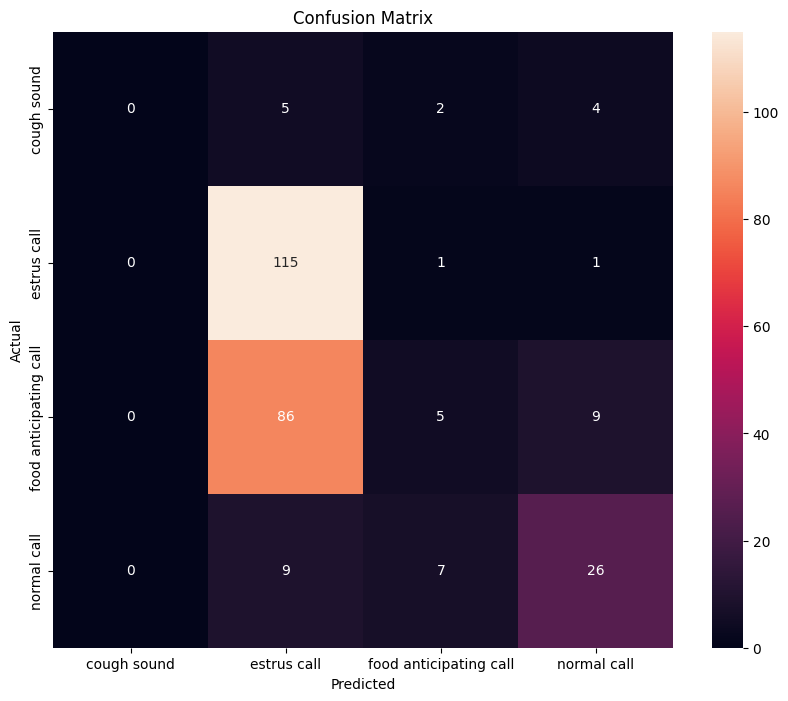

Accuracy: 54.07%
Precision: 37.96%
Recall: 41.30%
F1 Score: 35.35%


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image
import noisereduce as nr
from tensorflow.keras.preprocessing.image import img_to_array
from vit_keras import vit

# Constants
SAMPLE_RATE = 22050
STFT_WINDOW_LENGTH = 2048
HOP_LENGTH = 256
N_MFCC = 13
N_FFT = 2048
IMAGE_SIZE = (224, 224)  # Input size for Vision Transformer

# Define the base directory paths for preprocessed audio files
base_test_dir = r'/content/drive/MyDrive/pres_new1'

# Output directory for MFCC images
mfcc_output_dir = r'/content/drive/MyDrive/mfcc2_4_test'
os.makedirs(mfcc_output_dir, exist_ok=True)

# Load the trained Vision Transformer model
model_path = r'/content/drive/MyDrive/weight_file/vit_model.h5'  # Path to your Vision Transformer model
model = tf.keras.models.load_model(model_path)

# Assuming class indices mapping
class_indices = {'cough sound': 0, 'estrus call': 1, 'food anticipating call': 2, 'normal call': 3}
index_to_class = {v: k for k, v in class_indices.items()}

predicted_labels = []
true_labels = []

def preprocess_audio(audio_input_path, preprocessed_output_path):
    y, sr = librosa.load(audio_input_path, sr=SAMPLE_RATE)
    clean_signal = nr.reduce_noise(y=y, sr=sr)
    sf.write(preprocessed_output_path, clean_signal, sr)

def generate_mfcc_image(preprocessed_audio_path, mfcc_image_output_path):
    y, sr = librosa.load(preprocessed_audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.savefig('temp_mfcc.png')
    plt.close()

    # Open the saved image and convert it to RGB
    image = Image.open('temp_mfcc.png')
    rgb_image = image.convert('RGB')
    resized_image = rgb_image.resize(IMAGE_SIZE)
    resized_image.save(mfcc_image_output_path)


def predict_class(mfcc_image_path, model):
    img = Image.open(mfcc_image_path)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index

# Process each category
for category in class_indices:
    category_dir = os.path.join(base_test_dir, category)
    output_category_dir = os.path.join(mfcc_output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    # Process each audio file in the category directory
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            audio_input_path = os.path.join(category_dir, filename)
            preprocessed_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_preprocessed.wav")
            mfcc_image_output_path = os.path.join(output_category_dir, f"{os.path.splitext(filename)[0]}_mfcc.png")

            # Step 1: Preprocess the audio
            preprocess_audio(audio_input_path, preprocessed_output_path)

            # Step 2: Generate MFCC Image
            generate_mfcc_image(preprocessed_output_path, mfcc_image_output_path)

            # Step 3: Predict the class of the audio
            predicted_class_index = predict_class(mfcc_image_output_path, model)
            predicted_labels.append(predicted_class_index)
            true_labels.append(class_indices[category])

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


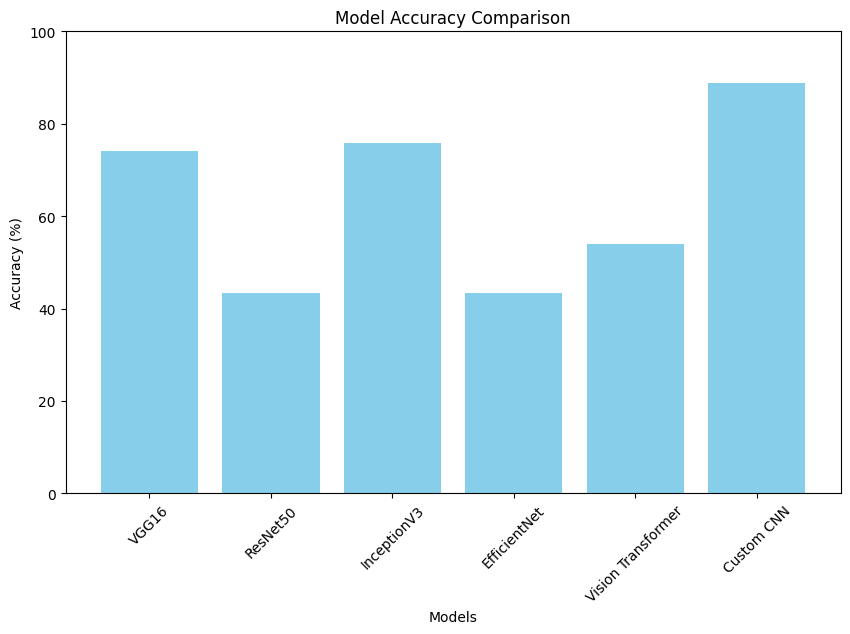

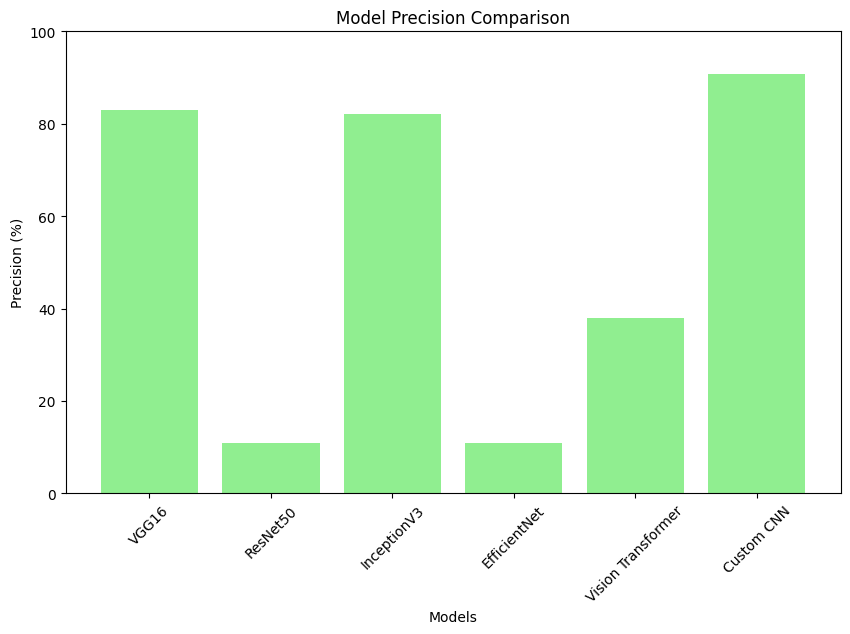

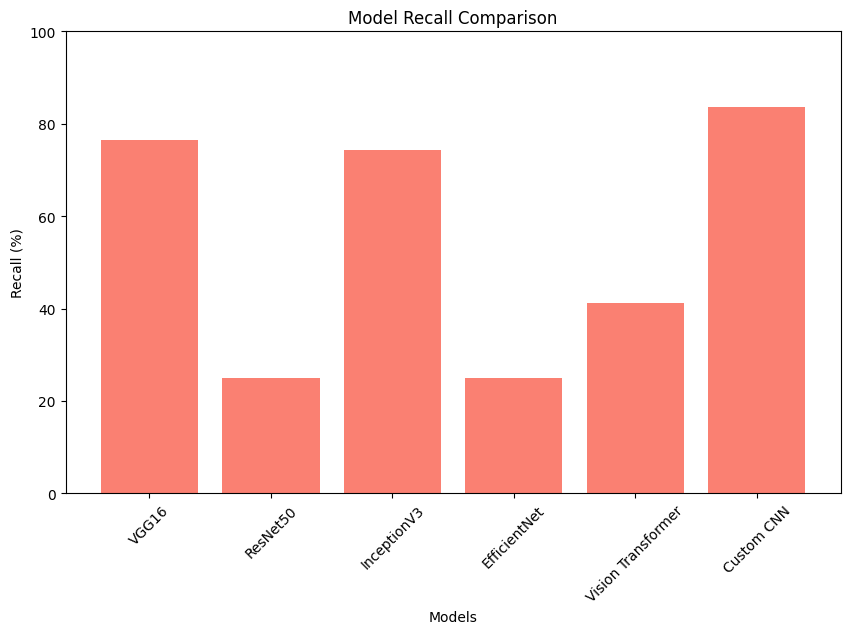

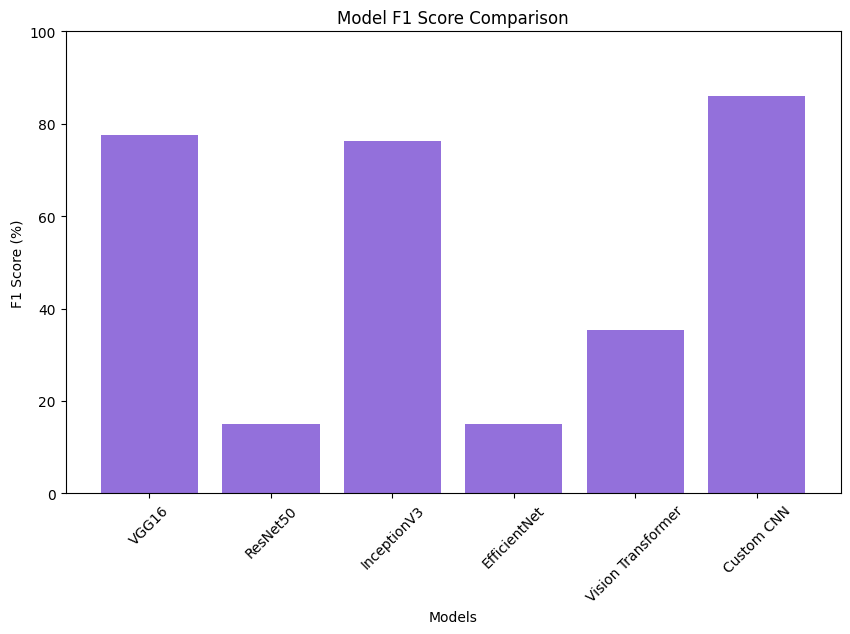

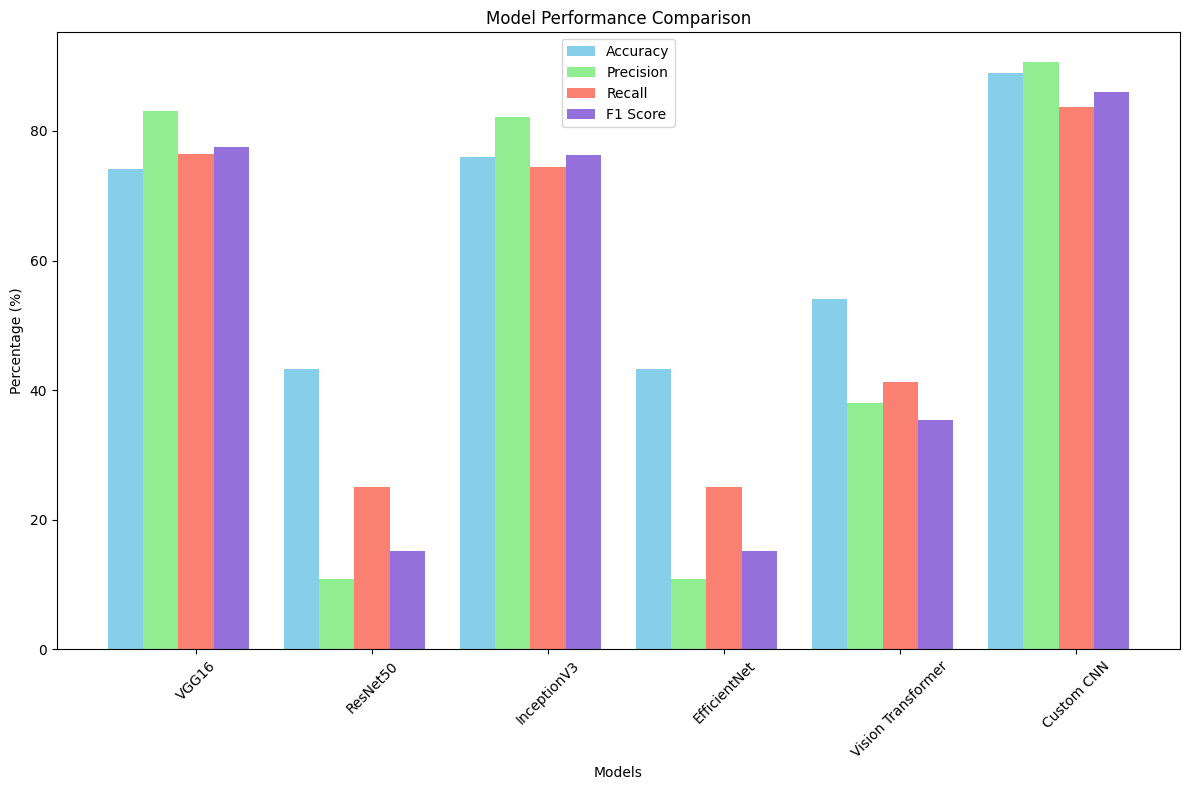

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their performance metrics
models = ['VGG16', 'ResNet50', 'InceptionV3', 'EfficientNet', 'Vision Transformer', 'Custom CNN']
accuracy = [74.07, 43.33, 75.93, 43.33, 54.07, 88.89]
precision = [83.08, 10.83, 82.18, 10.83, 37.96, 90.69]
recall = [76.52, 25.00, 74.42, 25.00, 41.30, 83.70]
f1_score = [77.59, 15.12, 76.34, 15.12, 35.35, 86.09]

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# Plot precision
plt.figure(figsize=(10, 6))
plt.bar(models, precision, color='lightgreen')
plt.xlabel('Models')
plt.ylabel('Precision (%)')
plt.title('Model Precision Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# Plot recall
plt.figure(figsize=(10, 6))
plt.bar(models, recall, color='salmon')
plt.xlabel('Models')
plt.ylabel('Recall (%)')
plt.title('Model Recall Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# Plot F1-score
plt.figure(figsize=(10, 6))
plt.bar(models, f1_score, color='mediumpurple')
plt.xlabel('Models')
plt.ylabel('F1 Score (%)')
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()

# Plot all metrics together for comparison
x = np.arange(len(models))
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x - width, precision, width, label='Precision', color='lightgreen')
rects3 = ax.bar(x, recall, width, label='Recall', color='salmon')
rects4 = ax.bar(x + width, f1_score, width, label='F1 Score', color='mediumpurple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Percentage (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

fig.tight_layout()

plt.show()
